In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.variable import Variable
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import imageio
import numpy as np
from matplotlib import pyplot as plt

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:

transform = transforms.Compose([
                transforms.Resize((128, 128)),
                transforms.ToTensor(),
                transforms.Normalize((0.5),(0.5))
                ])
to_image = transforms.ToPILImage()
trainset = MNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14929283.71it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 505203.58it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4063715.67it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1764754.87it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:

import matplotlib.pyplot as plt
def show_images(images):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach(), nrow=22).permute(1, 2, 0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break

In [ ]:
show_batch(trainloader)

In [6]:
import numpy as np
latent_dim = 128
n_classes = 10
embedding_dim = 100
image_shape = (1, 128, 128)
image_dim = int(np.prod(image_shape))


In [7]:
# custom weights initialization called on generator and discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()


        self.label_conditioned_generator = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 16))


        self.latent = nn.Sequential(nn.Linear(latent_dim, 4*4*512),
                                   nn.LeakyReLU(0.2, inplace=True))


        self.model = nn.Sequential(nn.ConvTranspose2d(513, 64*8, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*2, 64*1, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*1, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*1, 1, 4, 2, 1, bias=False),
                      nn.Tanh())

    def forward(self, imgs, labels):
        noise_vector, label = imgs, labels
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 4, 4)
        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 512,4,4)
        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        #print(image.size())
        return image

generator = Generator().to(device)
generator.apply(weights_init)
print(generator)

a = torch.ones(100,128)
b = torch.ones(100) #1*128 128*8192
b = b.long()
a = a.to(device)
b = b.to(device)
c=generator(a,b)
c.size()


Generator(
  (label_conditioned_generator): Sequential(
    (0): Embedding(10, 100)
    (1): Linear(in_features=100, out_features=16, bias=True)
  )
  (latent): Sequential(
    (0): Linear(in_features=128, out_features=8192, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(513, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_s

torch.Size([100, 1, 128, 128])

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()


        self.label_condition_disc = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 1*128*128))

        self.model = nn.Sequential(nn.Conv2d(2, 64, 4, 2, 1, bias=False),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64, 64*2, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*2, 64*4, 4, 3,2, bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*4, 64*8, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Flatten(),
                      nn.Dropout(0.4),
                      nn.Linear(4608, 1),
                      nn.Sigmoid()
                     )

    def forward(self, imgs, labels):
        img, label = imgs, labels
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 1, 128, 128)
        concat = torch.cat((img, label_output), dim=1)
        #print(concat.size())
        output = self.model(concat)
        return output

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

a = torch.ones(2,1,128,128)
b = torch.ones(2,1)
b = b.long()
a = a.to(device)
b = b.to(device)
c = discriminator(a,b)
c.size()


Discriminator(
  (label_condition_disc): Sequential(
    (0): Embedding(10, 100)
    (1): Linear(in_features=100, out_features=16384, bias=True)
  )
  (model): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (6): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (9): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)

torch.Size([2, 1])

In [10]:
g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

g_losses = []
d_losses = []
images = []

criterion = nn.BCELoss()

def noise(n, latent_dim=128):
    return Variable(torch.randn(n, latent_dim)).to(device)

def make_ones(size):
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def make_zeros(size):
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

In [11]:
def train_discriminator(optimizer, real_data, labels, fake_data):
    n = real_data.size(0)

    optimizer.zero_grad()

    prediction_real = discriminator(real_data, labels)
    error_real = criterion(prediction_real, make_ones(n))
    error_real.backward()

    prediction_fake = discriminator(fake_data,labels)
    error_fake = criterion(prediction_fake, make_zeros(n))

    error_fake.backward()
    optimizer.step()

    return error_real + error_fake

def train_generator(optimizer, labels, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()

    prediction = discriminator(fake_data, labels)
    error = criterion(prediction, make_ones(n))

    error.backward()
    optimizer.step()

    return error

In [13]:
!mkdir GANs

In [14]:
num_epochs = 20
k = 1
test_noise = noise(100)

generator.train()
discriminator.train()
for epoch in range(num_epochs):
    g_error = 0.0
    d_error = 0.0
    for i, data in enumerate(trainloader):
        imgs, labels = data
        labels = labels.to(device)
        # labels = labels.unsqueeze(1).long()

        n = len(imgs)
        for j in range(k):
            fake_data = generator(noise(100),labels).detach()
            real_data = imgs.to(device)
            d_error += train_discriminator(d_optim, real_data, labels, fake_data)
        fake_data = generator(noise(100), labels)
        g_error += train_generator(g_optim, labels,fake_data)
        print('Epoch {}: g_loss: {:.8f} d_loss: {:.8f}\r'.format(epoch, g_error/i, d_error/i))

    img = generator(test_noise, labels).cpu().detach()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_error/i)
    d_losses.append(d_error/i)
    print('Epoch {}: g_loss: {:.8f} d_loss: {:.8f}\r'.format(epoch, g_error/i, d_error/i))


print('Training Finished')
torch.save(generator.state_dict(), '/content/GANs/CGAN_20.pth')

Streaming output truncated to the last 5000 lines.
Epoch 11: g_loss: 3.04739308 d_loss: 0.58318621
Epoch 11: g_loss: 3.05277228 d_loss: 0.58271283
Epoch 11: g_loss: 3.05943632 d_loss: 0.58251786
Epoch 11: g_loss: 3.06522703 d_loss: 0.58521086
Epoch 11: g_loss: 3.06267619 d_loss: 0.58547175
Epoch 11: g_loss: 3.05763412 d_loss: 0.58547997
Epoch 11: g_loss: 3.05600810 d_loss: 0.58483595
Epoch 11: g_loss: 3.05508208 d_loss: 0.58783990
Epoch 11: g_loss: 3.06369758 d_loss: 0.58729202
Epoch 11: g_loss: 3.07165480 d_loss: 0.58761525
Epoch 11: g_loss: 3.07607317 d_loss: 0.58889282
Epoch 11: g_loss: 3.07142043 d_loss: 0.58862543
Epoch 11: g_loss: 3.06771851 d_loss: 0.58856094
Epoch 11: g_loss: 3.06616068 d_loss: 0.58903784
Epoch 11: g_loss: 3.07166672 d_loss: 0.58866096
Epoch 11: g_loss: 3.08135438 d_loss: 0.58800066
Epoch 11: g_loss: 3.09266305 d_loss: 0.58868200
Epoch 11: g_loss: 3.09633017 d_loss: 0.58848739
Epoch 11: g_loss: 3.09850502 d_loss: 0.58763134
Epoch 11: g_loss: 3.09476471 d_loss: 

In [15]:
#saving progress image
import numpy as np
from matplotlib import pyplot as plt
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('/content/GANs/CGAN_progress.gif', imgs)

In [16]:
#converting to tensor
print(type(g_losses))
g_losses_T = torch.tensor(g_losses)
print(type(g_losses_T))

print(type(d_losses))
d_losses_T = torch.tensor(d_losses)
print(type(d_losses_T))


<class 'list'>
<class 'torch.Tensor'>
<class 'list'>
<class 'torch.Tensor'>


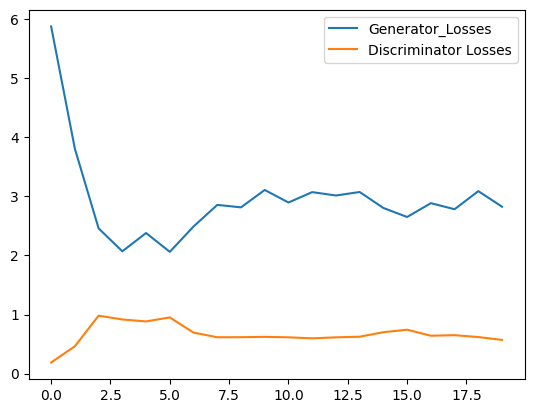

In [17]:

#plotting loss
plt.plot(g_losses_T, label='Generator_Losses')
plt.plot(d_losses_T, label='Discriminator Losses')
plt.legend()
plt.savefig('/content/GANs/CGAN_loss.png')

In [18]:
#printing loss values
print(g_losses[0])
print(g_losses[-1])

print(d_losses[0])
print(d_losses[-1])

tensor(5.8760, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.8253, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1889, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5708, device='cuda:0', grad_fn=<DivBackward0>)


<ipython-input-19-d0eaa66966dd>:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  plt.imshow(images[-1].T)


<class 'torch.Tensor'>
torch.Size([3, 1692, 1042])


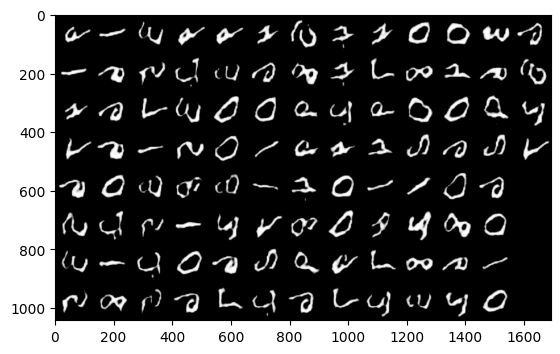

In [19]:

print(type(images[0]))
print(images[0].shape)
plt.imshow(images[-1].T)

In [20]:

# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [23]:
# example of interpolating between generated faces
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from matplotlib import pyplot
from matplotlib import gridspec

def dupnoise(n, n_features=128):
    return Variable(torch.randn(n, n_features)).to(device)

# randomly generated, new latent vectors
sample_size=100
rand_z = dupnoise(sample_size)
generator.eval()# eval mode

label = 3
labels = torch.ones(100) * label
labels = labels.to(device)
labels = labels.unsqueeze(1).long()
predictions = generator(rand_z, labels)
predictions = predictions.permute(0,2,3,1)
pred = predictions.detach().cpu()


RuntimeError: shape '[28, 28]' is invalid for input of size 16384

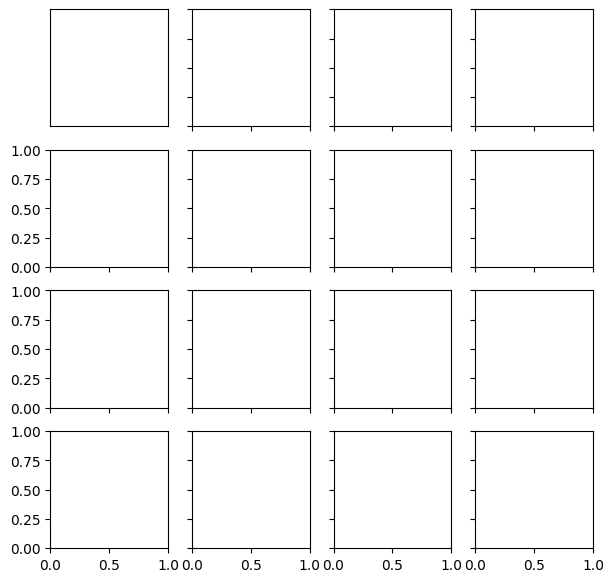

In [24]:

view_samples(-1, [pred])

In [25]:
# example of interpolating between generated faces
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from matplotlib import pyplot
from matplotlib import gridspec

def dupnoise(n, n_features=128):
    return Variable(torch.randn(n, n_features)).to(device)

# randomly generated, new latent vectors
sample_size=100
rand_z = dupnoise(sample_size)
generator.eval()# eval mode

label = 5
labels = torch.ones(100) * label
labels = labels.to(device)
labels = labels.unsqueeze(1).long()
predictions = generator(rand_z, labels)
predictions = predictions.permute(0,2,3,1)
pred = predictions.detach().cpu()

In [26]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((128,128)), cmap='Greys_r')

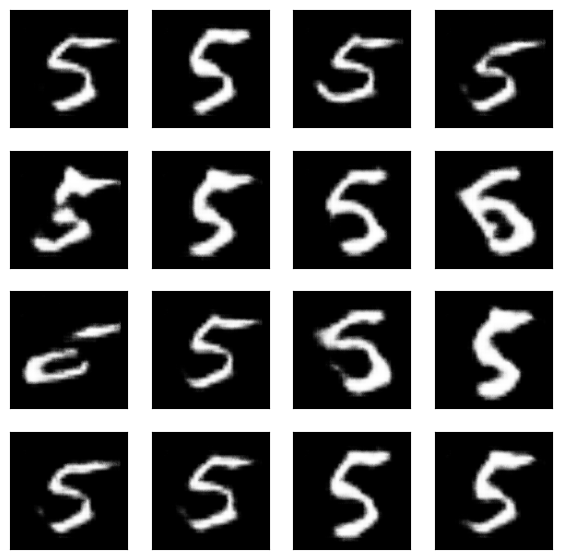

In [27]:
view_samples(-1, [pred])

In [28]:
# example of interpolating between generated faces
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from matplotlib import pyplot
from matplotlib import gridspec

def dupnoise(n, n_features=128):
    return Variable(torch.randn(n, n_features)).to(device)

# randomly generated, new latent vectors
sample_size=100
rand_z = dupnoise(sample_size)
generator.eval()# eval mode

label = 7
labels = torch.ones(100) * label
labels = labels.to(device)
labels = labels.unsqueeze(1).long()
predictions = generator(rand_z, labels)
predictions = predictions.permute(0,2,3,1)
pred = predictions.detach().cpu()


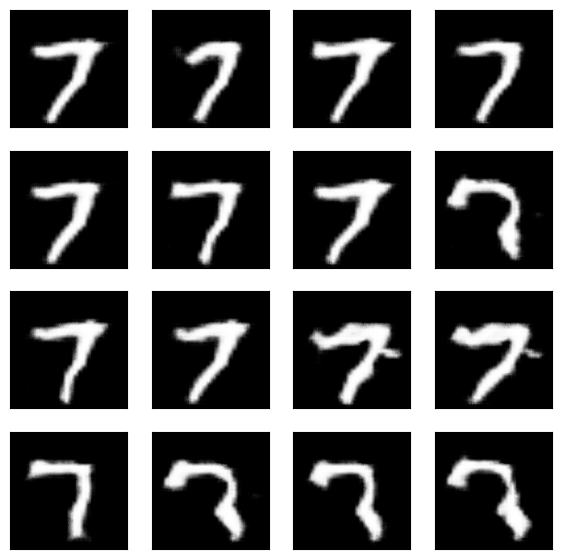

In [29]:
view_samples(-1, [pred])

reference:

https://learnopencv.com/deep-convolutional-gan-in-pytorch-and-tensorflow/

https://learnopencv.com/conditional-gan-cgan-in-pytorch-and-tensorflow/